# Panama Traits Analysis for defining parameters for a FATES ensemble

#### First import various libraries

In [1]:
import pandas
import numpy as np
# import map_funcs
import sys
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-ticks')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5, "lines.markersize": 6.0, 'lines.markeredgewidth': 1.0})


#### Here we define some temperature scaling functions.  These will be used later to translate vcmax$_T$ to vcmax$_{25}$ values.

In [2]:
global tfrz
global rgas
tfrz = 273.15
rgas = 8314.4598

### temperature functions for scaling vcmax and jmax to temperatures
def ft1_f(tl, ha):
    # from FATES code
    # !
    # !!DESCRIPTION:
    # ! photosynthesis temperature response
    # !
    # ! !ARGUMENTS:
    # real(r8), intent(in) :: tl  ! leaf temperature in photosynthesis temperature function (K)
    # real(r8), intent(in) :: ha  ! activation energy in photosynthesis temperature function (J/mol)
    #
    ans = np.exp( ha / (rgas*1.e-3*(tfrz+25.)) * (1. - (tfrz+25.)/tl) )
    #
    return ans

def fth_f(tl,hd,se,scaleFactor):
    # From FATES code
    # !
    # !!DESCRIPTION:
    # !photosynthesis temperature inhibition
    # !
    # ! !ARGUMENTS:
    # real(r8), intent(in) :: tl  ! leaf temperature in photosynthesis temp function (K)
    # real(r8), intent(in) :: hd  ! deactivation energy in photosynthesis temp function (J/mol)
    # real(r8), intent(in) :: se  ! entropy term in photosynthesis temp function (J/mol/K)
    # real(r8), intent(in) :: scaleFactor  ! scaling factor for high temp inhibition (25 C = 1.0)
    #
    ans = scaleFactor / ( 1. + np.exp( (-hd+se*tl) / (rgas*1.e-3*tl) ) )
    #
    return ans

def fth25_f(hd,se):
    # From FATES code
    # !
    # !!DESCRIPTION:
    # ! scaling factor for photosynthesis temperature inhibition
    # !
    # ! !ARGUMENTS:
    # real(r8), intent(in) :: hd    ! deactivation energy in photosynthesis temp function (J/mol)
    # real(r8), intent(in) :: se    ! entropy term in photosynthesis temp function (J/mol/K)
    #
    ans = 1. + np.exp( (-hd+se*(tfrz+25.)) / (rgas*1.e-3*(tfrz+25.)) )
    #
    return ans

# Ingest all the observational trait datasets

#### First the Wright et al trait data for BCI

In [3]:
wright_bci_traits_filename = 'traits_data/Wright/BCITRAITS_20101220.xls'
wright_bci_traits_file = pandas.read_excel(wright_bci_traits_filename)
wright_bci_traits_file.columns = wright_bci_traits_file.columns.str.replace('$', '')
wright_bci_specieslist = wright_bci_traits_file.loc[:].GENUS + ' ' + wright_bci_traits_file.loc[:].SPECIES
wright_bci_wooddensity1 = np.ma.masked_invalid(np.ma.asarray(wright_bci_traits_file.loc[:].SG100C_AVG))
wright_bci_wooddensity2 = np.ma.masked_invalid(np.ma.asarray(wright_bci_traits_file.loc[:].WSG_CHAVE))
wright_bci_wooddensity = np.ma.column_stack((wright_bci_wooddensity1,wright_bci_wooddensity2)).mean(axis=1)
wright_bci_mortality10cm = np.ma.masked_invalid(np.ma.asarray(wright_bci_traits_file.loc[:].MORT_100))
wright_bci_lma = np.ma.masked_invalid(np.ma.asarray(wright_bci_traits_file.loc[:].LMALEAF_AVD))

# map_funcs.xyplot(wright_bci_wooddensity,wright_bci_lma, dots=True, file='lma_vs_wooddensity', xtitle='wood density', ytitle='LMA')

*** No CODEPAGE record, no encoding_override: will use 'ascii'


#### Ingest the Rogers et al. Leaf vcmax data from the PNM and SLZ crane sites

In [4]:
rogers_panama_vcmax_filename = 'traits_data/Rogers/2016ENSO_Panama_Fitted_Vcmax_Jmax.xlsx'
rogers_panama_vcmax_file = pandas.read_excel(rogers_panama_vcmax_filename, sheet_name=1)
nrows_rogers_vcmax_file = rogers_panama_vcmax_file.shape[0]

### open table linking species codes to species names from Rogers dataset
rogers_sepciestable_filename = 'traits_data/Rogers/species_code_table.xlsx'
rogers_sepciestable_file = pandas.read_excel(rogers_sepciestable_filename)
rogers_sepciestable_codes = rogers_sepciestable_file.Species_Code[:]
rogers_sepciestable_names = rogers_sepciestable_file.Species_Name[:]
rogers_sepciestable_codes_list = list(rogers_sepciestable_codes)

# create a mapping array that allows us to group observations by species
species_code_list_rogers_vcmaxfile = []
species_name_list_rogers_vcmaxfile = []
species_list_rogers_vcmaxfile_index = np.ma.masked_all(nrows_rogers_vcmax_file)
for i in range(nrows_rogers_vcmax_file):
    species = rogers_panama_vcmax_file.Species[i]
    if not species in species_code_list_rogers_vcmaxfile:
        species_code_list_rogers_vcmaxfile.append(species)
        if species in rogers_sepciestable_codes_list:
            species_name_list_rogers_vcmaxfile.append(rogers_sepciestable_names[rogers_sepciestable_codes_list.index(species)])
        else:
            print(' no species name for code '+species)
            species_name_list_rogers_vcmaxfile.append(species)
    species_list_rogers_vcmaxfile_index[i] = species_code_list_rogers_vcmaxfile.index(species)

nspecies = len(species_code_list_rogers_vcmaxfile)

mean_species_vcmax25 = np.ma.masked_all(nspecies)
#mean_species_vcmax = np.ma.masked_all(nspecies)

### we need temperature scaling factors to get from vcmax to vcmax25
vcmaxha = 65330
vcmaxhd = 149250
vcmaxse = 485
vcmaxc = fth25_f(vcmaxhd, vcmaxse)

# get rid of dots in column header names
rogers_panama_vcmax_file.columns = rogers_panama_vcmax_file.columns.str.replace('.', '')

# sanity check on vcmax temperature scaling
# tleaf = np.linspace(0.,35.,100)
# scalar = (ft1_f(tleaf+tfrz, vcmaxha) * fth_f(tleaf+tfrz, vcmaxhd, vcmaxse, vcmaxc))
# # map_funcs.xyplot(tleaf, scalar)

for i in range(nspecies):
    # extract leaf temeprature and put in K
    veg_tempk = tfrz + np.ma.masked_array(rogers_panama_vcmax_file.MeanTleaf[:], mask = species_list_rogers_vcmaxfile_index != i)
    vcmax25 = np.ma.masked_array(rogers_panama_vcmax_file.Vcmax[:], mask = species_list_rogers_vcmaxfile_index != i) / (ft1_f(veg_tempk, vcmaxha) * fth_f(veg_tempk, vcmaxhd, vcmaxse, vcmaxc))
    mean_species_vcmax25[i] = vcmax25.mean()
    # mean_species_vcmax[i] = np.ma.masked_array(rogers_panama_vcmax_file.Vcmax[:], mask = species_list_rogers_vcmaxfile_index != i).mean()



# ### Ingest Rogers et al LMA data:
# ### actually lets not use these, as they are only for four species...
# rogers_slz_lma_filename = 'traits_data/Rogers/2017_SLZ_LMA_ByAge.xlsx'
# rogers_slz_lma_file = pandas.read_excel(rogers_slz_lma_filename, sheet_name=2)
# nrows_rogers_slz_lma_file = rogers_slz_lma_file.shape[0]
# # create a mapping array that allows us to group observations by species
# species_list_rogers_slafile = []
# species_list_rogers_slafile_index = np.ma.masked_all(nrows_rogers_slz_lma_file)
# for i in range(nrows_rogers_slz_lma_file):
#     species = rogers_slz_lma_file.Species[i]
#     if not species in species_list_rogers_slafile:
#         species_list_rogers_slafile.append(species)
#     species_list_rogers_slafile_index[i] = species_list_rogers_slafile.index(species)

   

 no species name for code CECRSP


#### Ingest Norby et al leaf vcmax data from the Panama crane sites

In [5]:
norby_panama_leaftraits_file = 'traits_data/Norby/Panama_post.xlsx'
norby_panama_leaftraits = pandas.read_excel(norby_panama_leaftraits_file)
norby_panama_leaftraits.columns = norby_panama_leaftraits.columns.str.replace(' ', '')
nrows_norby_panama_leaftraits = norby_panama_leaftraits.shape[0] -1 # ignore the last row of this because they put units in it
norby_panama_vcmax = np.ma.masked_invalid(np.ma.masked_array(norby_panama_leaftraits.Vcmax25[0:nrows_norby_panama_leaftraits], dtype=np.float32))
norby_panama_lma = np.ma.masked_invalid(np.ma.masked_array(norby_panama_leaftraits.LMA[0:nrows_norby_panama_leaftraits], dtype=np.float32))
norby_panama_nmass = np.ma.masked_invalid(np.ma.masked_array(norby_panama_leaftraits.Nmass[0:nrows_norby_panama_leaftraits], dtype=np.float32))
norby_panama_wooddens = np.ma.masked_invalid(np.ma.masked_array(norby_panama_leaftraits.wooddensity[0:nrows_norby_panama_leaftraits], dtype=np.float32))
norby_panama_specieslist = norby_panama_leaftraits.Species

#### Ingest Wright et al leaf traits database for wet and dry forests at SLZ and PNM

In [6]:
wright_pnm_slz_leaf_traits_filename = 'traits_data/Wright/LFTRAITS.xlsx'
wright_pnm_slz_leaf_traits_file = pandas.read_excel(wright_pnm_slz_leaf_traits_filename)
wright_pnm_slz_leaf_traits_file.columns = wright_pnm_slz_leaf_traits_file.columns.str.replace('$', '')
wright_pnm_slz_speciescodelist = wright_pnm_slz_leaf_traits_file.SP4
wright_pnm_slz_specieslist = wright_pnm_slz_leaf_traits_file.GENUS + ' ' + wright_pnm_slz_leaf_traits_file.SPECIES
wright_pnm_slz_strata = wright_pnm_slz_leaf_traits_file.STRATA
wright_pnm_slz_iscanopy = np.array(wright_pnm_slz_strata == 'CANOPY', dtype=np.bool)
wright_pnm_slz_lifeform6 = wright_pnm_slz_leaf_traits_file.LIFEFORM6
wright_pnm_slz_istree = np.array(wright_pnm_slz_lifeform6 == 'TREE', dtype=np.bool)
wright_pnm_slz_lifetime = np.ma.masked_invalid(wright_pnm_slz_leaf_traits_file.LIFETIME)
wright_pnm_slz_sla = np.ma.masked_invalid(wright_pnm_slz_leaf_traits_file.SLA_LEAF)
wright_pnm_slz_lma = np.ma.masked_invalid(wright_pnm_slz_leaf_traits_file.LMA)
wright_pnm_slz_npct = np.ma.masked_invalid(wright_pnm_slz_leaf_traits_file.N_PCT)

#### Ingest Allometry data from Martinez_Cano et al paper

In [7]:
Martinez_Cano_filename = 'traits_data/Martinez_Cano/MartinezCano_allometry_data_from_article_meansonly.xlsx'
Martinez_Cano_file = pandas.read_excel(Martinez_Cano_filename)
Martinez_Cano_file.columns
#len(Martinez_Cano_file.Species)

Index([u'Species', u'TreeHeight_a', u'TreeHeight_b', u'TreeHeight_k',
       u'CrownArea_a', u'CrownArea_b'],
      dtype='object')

#### now we start to put together the various datasets into a single trait matrix, where we cross-reference all observations by species name, averaging traits where multiple observations exist for a given species.

In [8]:
master_species_list = []
master_LMA_list = []
master_Narea_list = []
master_wood_density_list = []
master_leaf_lifespan_list = []
master_vcmax25_list = []
master_mortality10cm_list = []
master_crownarea_coefficient_list = []
master_crownarea_exponent_list = []


## start with Wright et al., wet/dry forest data
for i in range(len(wright_pnm_slz_specieslist)):
    if wright_pnm_slz_iscanopy[i] and wright_pnm_slz_istree[i]:
        if not wright_pnm_slz_specieslist[i] in master_species_list:
            master_species_list.append(wright_pnm_slz_specieslist[i])
            master_LMA_list.append([])
            master_Narea_list.append([])
            master_wood_density_list.append([])
            master_leaf_lifespan_list.append([])
            master_vcmax25_list.append([])
            master_mortality10cm_list.append([])
            master_crownarea_coefficient_list.append([])
            master_crownarea_exponent_list.append([])
        indx = master_species_list.index(wright_pnm_slz_specieslist[i])
        if wright_pnm_slz_lma.mask[i] == False:
            master_LMA_list[indx].append(wright_pnm_slz_lma[i])
        if wright_pnm_slz_lifetime.mask[i] == False:
            master_leaf_lifespan_list[indx].append(wright_pnm_slz_lifetime[i])
        if wright_pnm_slz_npct.mask[i] == False:
            master_Narea_list[indx].append(wright_pnm_slz_npct[i] * .01 * wright_pnm_slz_lma[i])

## next add the wright BCI data
for i in range(len(wright_bci_specieslist)):
    if not wright_bci_specieslist[i] in master_species_list:
        master_species_list.append(wright_bci_specieslist[i])
        master_LMA_list.append([])
        master_Narea_list.append([])
        master_wood_density_list.append([])
        master_leaf_lifespan_list.append([])
        master_vcmax25_list.append([])
        master_mortality10cm_list.append([])
        master_crownarea_coefficient_list.append([])
        master_crownarea_exponent_list.append([])
    indx = master_species_list.index(wright_bci_specieslist[i])
    if wright_bci_wooddensity.mask[i] == False:
        master_wood_density_list[indx].append(wright_bci_wooddensity[i])
    if wright_bci_lma.mask[i] == False:
        master_LMA_list[indx].append(wright_bci_lma[i])
    if wright_bci_mortality10cm.mask[i] == False:
        master_mortality10cm_list[indx].append(wright_bci_mortality10cm[i])

## next add the Rogers data
for i in range(len(species_name_list_rogers_vcmaxfile)):
    if not species_name_list_rogers_vcmaxfile[i] in master_species_list:
        master_species_list.append(species_name_list_rogers_vcmaxfile[i])
        master_LMA_list.append([])
        master_Narea_list.append([])
        master_wood_density_list.append([])
        master_leaf_lifespan_list.append([])
        master_vcmax25_list.append([])
        master_mortality10cm_list.append([])
        master_crownarea_coefficient_list.append([])
        master_crownarea_exponent_list.append([])
    indx = master_species_list.index(species_name_list_rogers_vcmaxfile[i])
    if mean_species_vcmax25.mask[i] == False:
        master_vcmax25_list[indx].append(mean_species_vcmax25[i])

## next add the Norby data
for i in range(len(norby_panama_specieslist)-1):  ### they used nan to encode a phantom last species name
    if not norby_panama_specieslist[i] in master_species_list:
        master_species_list.append(norby_panama_specieslist[i])
        master_LMA_list.append([])
        master_Narea_list.append([])
        master_wood_density_list.append([])
        master_leaf_lifespan_list.append([])
        master_vcmax25_list.append([])
        master_mortality10cm_list.append([])
        master_crownarea_coefficient_list.append([])
        master_crownarea_exponent_list.append([])
    indx = master_species_list.index(norby_panama_specieslist[i])
    if norby_panama_vcmax.mask[i] == False:
        master_vcmax25_list[indx].append(norby_panama_vcmax[i])
    if norby_panama_lma.mask[i] == False:
        master_LMA_list[indx].append(norby_panama_lma[i])
    if norby_panama_nmass.mask[i] == False:
        master_Narea_list[indx].append(norby_panama_nmass[i] * .001 * norby_panama_lma[i])
    if norby_panama_wooddens.mask[i] == False:
        master_wood_density_list[indx].append(norby_panama_wooddens[i])

## next add the Martinez-Cano data        
for i in range(len(Martinez_Cano_file.Species)):
    if not Martinez_Cano_file.Species[i] in master_species_list:
        master_species_list.append(Martinez_Cano_file.Species[i])
        master_LMA_list.append([])
        master_Narea_list.append([])
        master_wood_density_list.append([])
        master_leaf_lifespan_list.append([])
        master_vcmax25_list.append([])
        master_mortality10cm_list.append([])
        master_crownarea_coefficient_list.append([])
        master_crownarea_exponent_list.append([])
    indx = master_species_list.index(Martinez_Cano_file.Species[i])
    master_crownarea_coefficient_list[indx].append(Martinez_Cano_file.CrownArea_a[i])
    master_crownarea_exponent_list[indx].append(Martinez_Cano_file.CrownArea_b[i])




### there are a couple artifacts to sort out still: 'Apeiba membranaceae' vs 'Apeiba membranacea'; 'Cojoba rufescens ' vs 'Cojoba rufescens', etc...
nspecies_master = len(master_species_list)
master_LMA_array = np.ma.masked_all(nspecies_master)
master_Narea_array = np.ma.masked_all(nspecies_master)
master_wood_density_array = np.ma.masked_all(nspecies_master)
master_leaf_lifespan_array = np.ma.masked_all(nspecies_master)
master_vcmax25_array = np.ma.masked_all(nspecies_master)
master_mort10cm_array = np.ma.masked_all(nspecies_master)
master_crownarea_coefficient_array = np.ma.masked_all(nspecies_master)
master_crownarea_exponent_array = np.ma.masked_all(nspecies_master)
for i in range(nspecies_master):
    if len(master_vcmax25_list[i]) > 0:
        master_vcmax25_array[i] = np.ma.masked_invalid(np.asarray(master_vcmax25_list[i]).mean()).flatten()
    if len(master_wood_density_list[i]) > 0:
        master_wood_density_array[i] = np.ma.masked_invalid(np.asarray(master_wood_density_list[i]).mean()).flatten()
    if len(master_LMA_list[i]) > 0:
        master_LMA_array[i] = np.ma.masked_invalid(np.asarray(master_LMA_list[i]).mean()).flatten()
    if len(master_Narea_list[i]) > 0:
        master_Narea_array[i] = np.ma.masked_invalid(np.asarray(master_Narea_list[i]).mean()).flatten()
    if len(master_leaf_lifespan_list[i]) > 0:
        master_leaf_lifespan_array[i] = np.ma.masked_invalid(np.asarray(master_leaf_lifespan_list[i]).mean()).flatten()     
    if len(master_mortality10cm_list[i]) > 0:
        master_mort10cm_array[i] = np.ma.masked_invalid(np.asarray(master_mortality10cm_list[i]).mean()).flatten()     
    if len(master_crownarea_coefficient_list[i]) > 0:
        master_crownarea_coefficient_array[i] = np.ma.masked_invalid(np.asarray(master_crownarea_coefficient_list[i]).mean()).flatten()     
    if len(master_crownarea_exponent_list[i]) > 0:
        master_crownarea_exponent_array[i] = np.ma.masked_invalid(np.asarray(master_crownarea_exponent_list[i]).mean()).flatten()     




master_LMA_array = master_LMA_array.flatten()
master_Narea_array = master_Narea_array.flatten()
master_wood_density_array = master_wood_density_array.flatten()
master_leaf_lifespan_array = master_leaf_lifespan_array.flatten()
master_vcmax25_array = master_vcmax25_array.flatten()
master_mort10cm_array = master_mort10cm_array.flatten()
master_crownarea_coefficient_array = master_crownarea_coefficient_array.flatten()
master_crownarea_exponent_array = master_crownarea_exponent_array.flatten()

# map_funcs.xyplot(master_LMA_array, master_leaf_lifespan_array, dots=True, xtitle='LMA', ytitle='leaf lifespan')
# map_funcs.xyplot(master_Narea_array, master_vcmax25_array, dots=True, xtitle='N per unit area', ytitle='vcmax')
# map_funcs.xyplot(master_wood_density_array, master_vcmax25_array, dots=True, xtitle='wood density', ytitle='vcmax')
# map_funcs.xyplot(master_wood_density_array, master_LMA_array, dots=True, xtitle='wood density', ytitle='LMA')


traits_matrix = np.ma.column_stack([master_vcmax25_array,master_wood_density_array,master_LMA_array,master_Narea_array,master_leaf_lifespan_array,master_mort10cm_array,master_crownarea_coefficient_array,master_crownarea_exponent_array,])
traits_matrix = np.ma.masked_invalid(traits_matrix)

vcmax25_indx = 0
wood_density_indx = 1
lma_indx = 2
n_area_indx = 3
lifespan_indx = 4
mortality_indx = 5
crown_to_dbh_coef_indx = 6
crown_to_dbh_exponent_indx = 7

column_names = ['Vcmax25', 'wood_density', 'LMA', 'N/area','lifespan','mortality','CrownArea_coef','CrownArea_exp']
df = pandas.DataFrame(traits_matrix, columns=column_names)

/Users/cdkoven/miniconda2/lib/python2.7/site-packages/numpy/core/numeric.py:492: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


#### Next we calculate a covariance matrix for the above

In [9]:
trait_cov = df.cov()
trait_cov

,Vcmax25,wood_density,LMA,N/area,lifespan,mortality,CrownArea_coef,CrownArea_exp
Vcmax25,616.837563,-1.427442,399.679850,9.308902,-2275.126519,-0.468932,-1.738784,1.100464
wood_density,-1.427442,0.021709,0.734569,-0.019823,4.561589,-0.105272,0.003516,0.001088
LMA,399.679850,0.734569,952.394759,15.044990,1591.950432,-13.539449,-1.110529,0.473155
N/area,9.308902,-0.019823,15.044990,0.352939,-11.232024,0.027366,-0.030828,0.008003
lifespan,-2275.126519,4.561589,1591.950432,-11.232024,23903.460405,1.238443,-3.557592,1.240788
mortality,-0.468932,-0.105272,-13.539449,0.027366,1.238443,10.267118,-0.004373,0.006367
CrownArea_coef,-1.738784,0.003516,-1.110529,-0.030828,-3.557592,-0.004373,0.034595,-0.011395
CrownArea_exp,1.100464,0.001088,0.473155,0.008003,1.240788,0.006367,-0.011395,0.007634


#### Plot the Trait covariance matrix as a series of pair-wise plots.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12138eed0>,
      dtype=object)

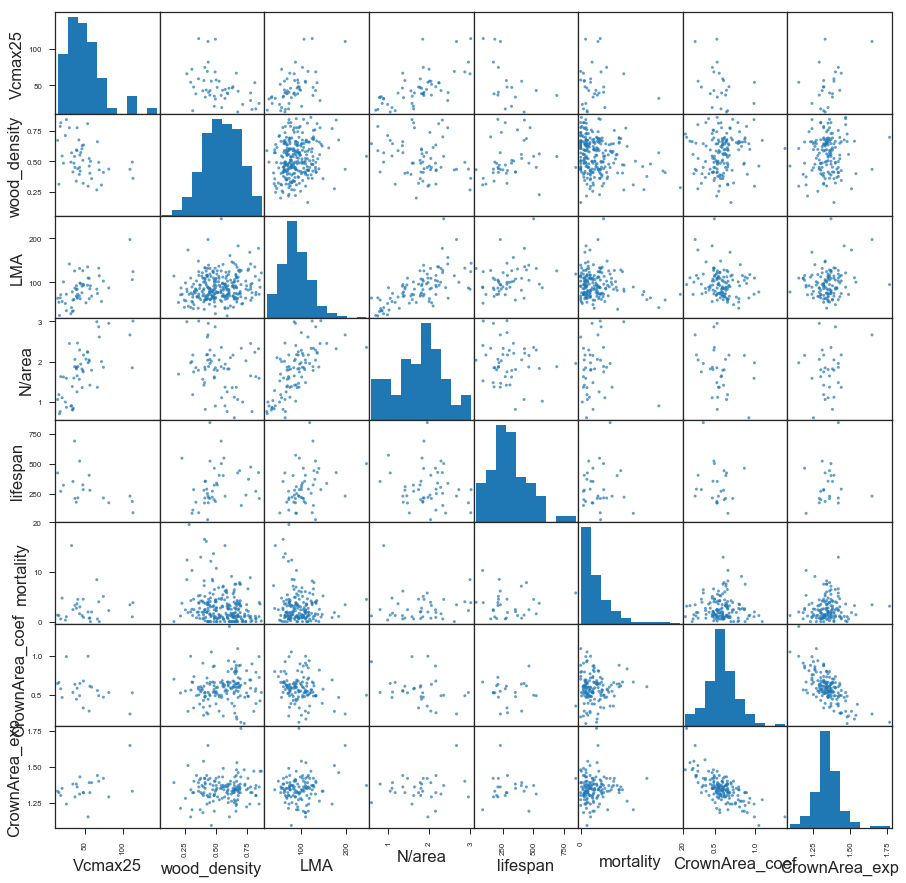

In [10]:
pandas.plotting.scatter_matrix(df, alpha=0.7, figsize=(15, 15), diagonal='hist')

#sns.pairplot(df, figsize=(15, 15), diagonal='hist')
# try seaborn version of scatter_matrix (gives error though, so sticking with pandas version)
#g = sns.pairplot(df)
#print(df)

#### Calculate a synthetic traits dataset where we assume that some of the traits are normally distributed, and some of them are lognormally distributed.

In [11]:
shape_out = [2,767]
n_out = np.zeros(shape_out).size
randomstate = np.random.RandomState(11)


### because of the large amount of missing data in the above, sample as a random draw from the trait
### covariance matrix instead, so that we can generate a large number of trait values to use for a FATES ensemble.
## we will actually skip this for now, so as to work with the partially-log-transformed dataset
#means = traits_matrix.mean(axis=0)
#X = randomstate.multivariate_normal(means, np.array(trait_cov), n_out)
#df2 = pandas.DataFrame(X, columns=column_names)
#pandas.plotting.scatter_matrix(df2, alpha=0.7, figsize=(15, 15), diagonal='hist')


### instead of doing the above on raw trait data, try defining covariance matrix off of log-transformed trait data for all traits
## we will actually skip this too, so as to work with the partially-log-transformed dataset
#log_traits_matrix = np.ma.log(traits_matrix)
#log_cov = np.ma.cov(log_traits_matrix.transpose())
#log_means = log_traits_matrix.mean(axis=0)
#X_log = np.exp(randomstate.multivariate_normal(log_means, np.array(log_cov), n_out))
#df3 = pandas.DataFrame(X_log, columns=column_names)
#pandas.plotting.scatter_matrix(df3, alpha=0.7, figsize=(15, 15), diagonal='hist')


### what we really want to do is treat some variables as normal and others as lognormal. 
### e.g. mortality is clearly not normally distributed.

partially_log_traits_matrix = traits_matrix.copy()

#print(partially_log_traits_matrix.shape)

## for now, assume that mortality and LMA are both lognormally distributed and define covariance matrix accordingly
columns_log = [2,5]
for i in range(len(columns_log)):
    partially_log_traits_matrix[:,columns_log[i]] = np.ma.log(partially_log_traits_matrix[:,columns_log[i]])

partially_log_cov = np.ma.cov(partially_log_traits_matrix.transpose())
partially_log_means = partially_log_traits_matrix.mean(axis=0)

## for now skip this, because we'll do it again later.
#X_partially_log = randomstate.multivariate_normal(partially_log_means, np.array(partially_log_cov), n_out)

#for i in range(len(columns_log)):
#    X_partially_log[:,columns_log[i]] = np.exp(X_partially_log[:,columns_log[i]])

#df4 = pandas.DataFrame(X_partially_log, columns=column_names)
#pandas.plotting.scatter_matrix(df4, alpha=0.7, figsize=(15, 15), diagonal='hist')



#### Now we'd like to add a few other traits to the mix, even though we don't have observations of all of what we want.  THe choice here is somewhat arbitrary, but we are focusing on some allometric parameters that we know to be important in governing the plant carbon economics.

/Users/cdkoven/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: covariance is not positive-semidefinite.
/Users/cdkoven/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: covariance is not positive-semidefinite.


(153400, 13)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12138f050>,
      dtype=object)

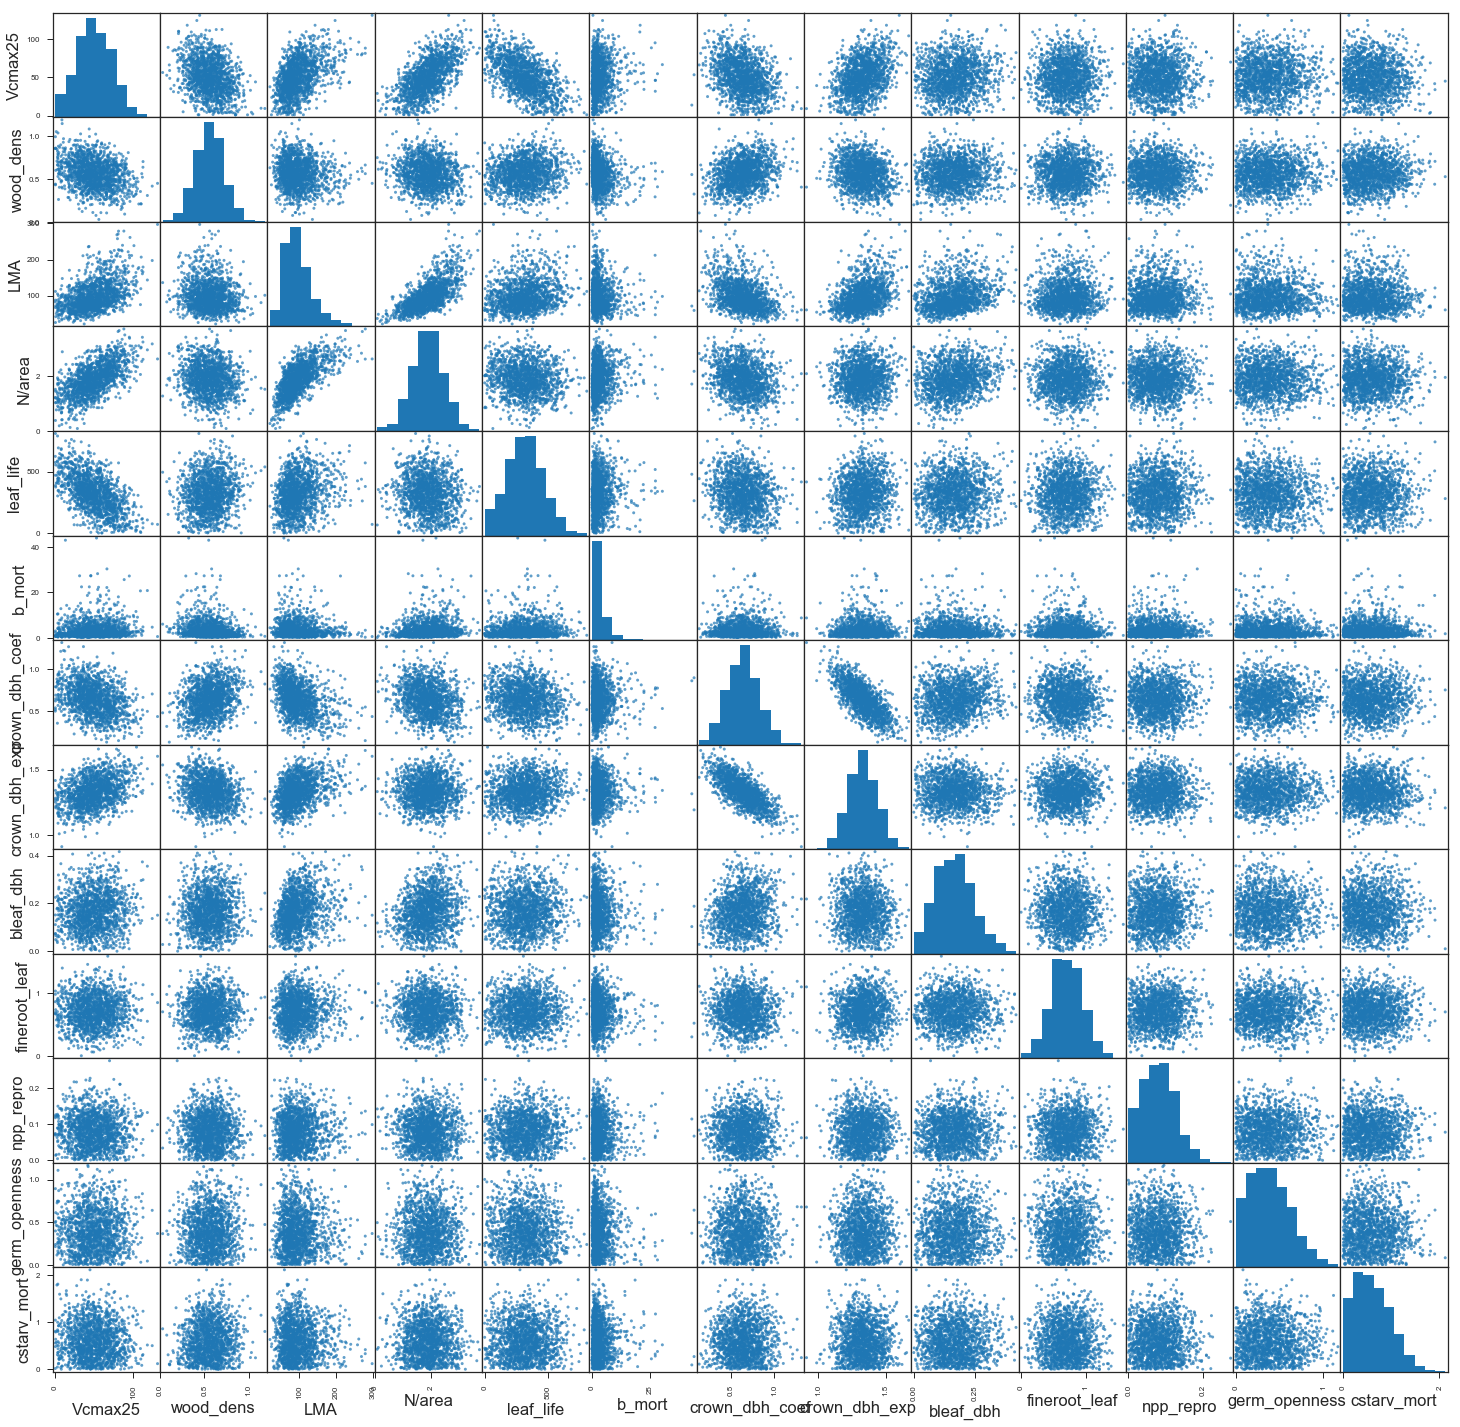

In [12]:
### these next sets of trait distributions are all completely made up.  

bleaf_to_dbh_mean = 0.2
bleaf_to_dbh_variance = (0.1)**2
bleaf_to_dbh_indx = 8

fineroot_to_leaf_mean = 0.7
fineroot_to_leaf_variance = (0.25)**2
fineroot_to_leaf_indx = 9

# parameters to vary
npp_repro_mean = 0.075
npp_repro_variance = (0.05)**2
npp_repro_indx = 10

germ_openness_param_mean = 0.3
germ_openness_param_variance = (0.3)**2
germ_openness_param_indx = 11

max_mort_rate_cstarve_mean = 0.5
max_mort_rate_cstarve_variance = (0.5)**2
max_mort_rate_cstarve_indx = 12




ntraits_total = 13
full_trait_cov_matrix = np.zeros([ntraits_total,ntraits_total])

# we are using the partially log-transformed traits covariance matrix now
full_trait_cov_matrix[0:8,0:8] = partially_log_cov[:]

#full_trait_cov_matrix[mortality_indx,mortality_indx] = mortality_variance
full_trait_cov_matrix[bleaf_to_dbh_indx,bleaf_to_dbh_indx] = bleaf_to_dbh_variance
full_trait_cov_matrix[fineroot_to_leaf_indx,fineroot_to_leaf_indx] = fineroot_to_leaf_variance
full_trait_cov_matrix[npp_repro_indx,npp_repro_indx] = npp_repro_variance
full_trait_cov_matrix[germ_openness_param_indx,germ_openness_param_indx] = germ_openness_param_variance
full_trait_cov_matrix[max_mort_rate_cstarve_indx,max_mort_rate_cstarve_indx] = max_mort_rate_cstarve_variance



means_total = np.zeros(ntraits_total)
# we are using the partially log-transformed traits covariance matrix now
means_total[0:8] = partially_log_means[:]

means_total[bleaf_to_dbh_indx] = bleaf_to_dbh_mean
means_total[fineroot_to_leaf_indx] = fineroot_to_leaf_mean
means_total[npp_repro_indx] = npp_repro_mean
means_total[germ_openness_param_indx] = germ_openness_param_mean
means_total[max_mort_rate_cstarve_indx] = max_mort_rate_cstarve_mean

backup_factor = 100
X_total = randomstate.multivariate_normal(means_total, np.array(full_trait_cov_matrix), n_out)
X_total_backup = randomstate.multivariate_normal(means_total, np.array(full_trait_cov_matrix), n_out*backup_factor)

#since we have log-transformed some of the traits data, need to get back to raw values
for i in range(len(columns_log)):
    X_total[:,columns_log[i]] = np.exp(X_total[:,columns_log[i]])
    X_total_backup[:,columns_log[i]] = np.exp(X_total_backup[:,columns_log[i]])


### all of these variables are positive definite.  go through them and check each row to make sure that all values
### in the row are positive.  if not, replace the entire row with one from a backup array.

### in addition, we need to ensure that the LAI of a tree with the maximum allowable SLA does not have an LAI 
### that exceeds the array sizes (dinc * nlevleaf) given to it.  pre-calculate the LAI of each ensemble member and 
### exclude trait combination draws that will exceed this value

carbon_fraction_mean = .4482  ## mean of leaf samples in norby dataset
carbon_fraction_used_in_fates = 0.5
sai_to_lai_ratio = 0.1
slamax_to_slatop = 2.0
max_allowable_lai = 12.5  #(assuming a dinc of 0.5 and a nlevleaf of 25)

print(X_total_backup.shape)

backup_copy = -1
for i in range(n_out):
    if X_total[i,:].min() <= 0 or ((slamax_to_slatop/(X_total[i,lma_indx] * carbon_fraction_mean))*(1.+sai_to_lai_ratio)*1e3*(carbon_fraction_used_in_fates)*X_total[i,bleaf_to_dbh_indx]/X_total[i,crown_to_dbh_coef_indx]) > max_allowable_lai:
        replacement_found = False
        backup_copy = backup_copy + 1
        #print('replacing '+str(i)+', '+str(X_total[i,:].min())+', '+str(((slamax_to_slatop/(X_total[i,lma_indx] * carbon_fraction_mean))*(1.+sai_to_lai_ratio)*1e3*(carbon_fraction_used_in_fates)*X_total[i,bleaf_to_dbh_indx]/X_total[i,crown_to_dbh_coef_indx])))
        while not replacement_found:
            if X_total_backup[backup_copy,:].min() > 0 and ((slamax_to_slatop/(X_total_backup[backup_copy,lma_indx] * carbon_fraction_mean))*(1.+sai_to_lai_ratio)*1e3*(carbon_fraction_used_in_fates)*X_total_backup[backup_copy,bleaf_to_dbh_indx]/X_total_backup[backup_copy,crown_to_dbh_coef_indx]) <= max_allowable_lai:
                replacement_found = True
            else:
                backup_copy = backup_copy + 1
                if backup_copy >= n_out*backup_factor -1:
                    backup_copy = 0
                    X_total_backup = randomstate.multivariate_normal(means_total, np.array(full_trait_cov_matrix), n_out*backup_factor)
                    for j in range(len(columns_log)):
                        X_total_backup[:,columns_log[j]] = np.exp(X_total_backup[:,columns_log[j]])
        X_total[i,:] = X_total_backup[backup_copy,:]
    #print('keeping '+str(i)+', '+str(X_total[i,:].min())+', '+str(((slamax_to_slatop/(X_total[i,lma_indx] * carbon_fraction_mean))*(1.+sai_to_lai_ratio)*1e3*(carbon_fraction_used_in_fates)*X_total[i,bleaf_to_dbh_indx]/X_total[i,crown_to_dbh_coef_indx])))
column_names_full = ['Vcmax25', 'wood_dens', 'LMA', 'N/area','leaf_life','b_mort','crown_dbh_coef','crown_dbh_exp','bleaf_dbh','fineroot_leaf','npp_repro','germ_openness','cstarv_mort']
df4 = pandas.DataFrame(X_total, columns=column_names_full)
pandas.plotting.scatter_matrix(df4, alpha=0.7, figsize=(25, 25), diagonal='hist')

#### now we want to write this full set of parameters to a set of fates netcdf parameter files, which we'll use to generate an ensemble of FATES runs.

In [13]:
### 
import netCDF4 as nc4
import sys
import os
import shutil

print(X_total.shape)

def copy_clobber(filename1, filename2):
    try:
        os.remove(filename2)
        print('replacing file: '+filename2)
    except:
        print('file does not yet exist: '+filename2)
    shutil.copyfile(filename1, filename2)

#print(carbon_fraction_mean * X_total[:,lma_indx] / X_total[:,n_area_indx])  #sanity check for leafcn
#print(1./X_total[:,lma_indx]) #sanity check for lma
#print(X_total[:,lifespan_indx]/365.25) #sanity check for leaf lifespan
#sys.exit()

#filename_template = 'fates_parameter_files/fates_params_default_c6ff126_mod4.nc'
#filename_template = 'fates_parameter_files/fates_params_default_770ac36_mod.nc'
#filename_template = 'fates_parameter_files/fates_params_default_3f10ad6_mod.nc'
filename_template = 'fates_parameter_files/fates_params_default_358720c_mod_2pfts.nc'
filename_output_basename = 'fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_'
for i in range(n_out/shape_out[0]):
    filename_out = filename_output_basename+str(i+1).zfill(4)+'.c181019.nc'
    copy_clobber(filename_template,filename_out)
    fin = nc4.Dataset(filename_out, 'r+')
    #
    vcmax25var = fin.variables['fates_leaf_vcmax25top']
    vcmax25var[:] = X_total[i*shape_out[0]:(i+1)*shape_out[0],vcmax25_indx]
    #
    wood_density_var = fin.variables['fates_wood_density']
    wood_density_var[:] = X_total[i*shape_out[0]:(i+1)*shape_out[0],wood_density_indx]
    #
    slatopvar = fin.variables['fates_leaf_slatop']
    slatopvar[:] = 1./(X_total[i*shape_out[0]:(i+1)*shape_out[0],lma_indx] * carbon_fraction_mean)
    #
    ### try making the maximum SLA (i.e. at the base of the canopy) equal to the top of the canopy value (i.e. turn off SLA scaling)
    slamaxvar = fin.variables['fates_leaf_slamax']
    slamaxvar[:] = slamax_to_slatop/(X_total[i*shape_out[0]:(i+1)*shape_out[0],lma_indx] * carbon_fraction_mean)
    #
    leafcnvar = fin.variables['fates_leaf_cn_ratio']
    leafcnvar[:] = carbon_fraction_mean * X_total[i*shape_out[0]:(i+1)*shape_out[0],lma_indx] / X_total[i*shape_out[0]:(i+1)*shape_out[0],n_area_indx]
    #
    leaflongvar = fin.variables['fates_leaf_long']
    leaflongvar[:] = X_total[i*shape_out[0]:(i+1)*shape_out[0],lifespan_indx]/365.25
    #
    bmortvar = fin.variables['fates_mort_bmort']
    bmortvar[:] = X_total[i*shape_out[0]:(i+1)*shape_out[0],mortality_indx] * 1e-2
    #
    crown_to_dbh_coef_var1 = fin.variables['fates_allom_d2ca_coefficient_min']
    crown_to_dbh_coef_var2 = fin.variables['fates_allom_d2ca_coefficient_max']
    crown_to_dbh_coef_var1[:] = X_total[i*shape_out[0]:(i+1)*shape_out[0],crown_to_dbh_coef_indx]
    crown_to_dbh_coef_var2[:] = X_total[i*shape_out[0]:(i+1)*shape_out[0],crown_to_dbh_coef_indx]
    #
    crown_to_dbh_exponent_var = fin.variables['fates_allom_d2bl2']
    crown_to_dbh_exponent_var[:] = X_total[i*shape_out[0]:(i+1)*shape_out[0],crown_to_dbh_exponent_indx]
    #
    bleaf_to_dbh_var = fin.variables['fates_allom_d2bl1']
    bleaf_to_dbh_var[:] = X_total[i*shape_out[0]:(i+1)*shape_out[0],bleaf_to_dbh_indx]
    #
    fineroot_to_leaf_var = fin.variables['fates_allom_l2fr']
    fineroot_to_leaf_var[:] = X_total[i*shape_out[0]:(i+1)*shape_out[0],fineroot_to_leaf_indx]
    #
    npp_reprovar = fin.variables['fates_seed_alloc']
    npp_reprovar[:] = X_total[i*shape_out[0]:(i+1)*shape_out[0],npp_repro_indx]
    #
    germ_openness_paramvar = fin.variables['fates_seed_germ_can_openness_param']
    germ_openness_paramvar[:] = X_total[i*shape_out[0]:(i+1)*shape_out[0],germ_openness_param_indx]
    #
    max_mort_rate_cstarvevar = fin.variables['fates_mort_scalar_cstarvation']
    max_mort_rate_cstarvevar[:] = X_total[i*shape_out[0]:(i+1)*shape_out[0],max_mort_rate_cstarve_indx]
    #
    fin.close()


(1534, 13)
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0001.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0002.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0003.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0004.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0005.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0006.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0007.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0008.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0009.c181019.nc
file does not yet exist: f

file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0106.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0107.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0108.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0109.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0110.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0111.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0112.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0113.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0114.c181019.nc
file does not yet exist: fates_parame

file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0189.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0190.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0191.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0192.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0193.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0194.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0195.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0196.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0197.c181019.nc
file does not yet exist: fates_parame

file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0294.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0295.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0296.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0297.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0298.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0299.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0300.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0301.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0302.c181019.nc
file does not yet exist: fates_parame

file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0402.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0403.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0404.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0405.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0406.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0407.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0408.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0409.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0410.c181019.nc
file does not yet exist: fates_parame

file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0515.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0516.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0517.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0518.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0519.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0520.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0521.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0522.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0523.c181019.nc
file does not yet exist: fates_parame

file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0628.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0629.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0630.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0631.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0632.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0633.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0634.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0635.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0636.c181019.nc
file does not yet exist: fates_parame

file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0706.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0707.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0708.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0709.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0710.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0711.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0712.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0713.c181019.nc
file does not yet exist: fates_parameter_files/fates_params_358720c_bcitraits_test03_2pfts_0714.c181019.nc
file does not yet exist: fates_parame

#### write the raw trait matrix out as a text file for easy analysis. of outputs against trait values.

In [15]:
print(X_total.shape)

np.savetxt('traits_matrix_used_in_param_files_180925_2pfts.txt', X_total)

(1534, 13)


traits_matrix_tonorm = partially_log_traits_matrix.copy()
traits_matrix_means = np.mean(traits_matrix_tonorm,axis=0)
traits_matrix_var = np.var(traits_matrix_tonorm,axis=0)
traits_matrix_norm = (traits_matrix_tonorm - traits_matrix_means) / traits_matrix_var
traits_matrix_norm_df = pandas.DataFrame(traits_matrix_norm, columns=column_names)
#pandas.plotting.scatter_matrix(traits_matrix_norm_df, alpha=0.7, figsize=(15, 15), diagonal='hist')
traits_matrix_norm_cov = traits_matrix_norm_df.cov()
eigenvalues, eigenvectors = np.linalg.eig(traits_matrix_norm_cov)
traits_matrix_norm_cov.shape
#eigenvalues
#eigenvectors
eigenvectors_df = pandas.DataFrame(eigenvectors, columns=column_names)
#pandas.plotting.scatter_matrix(eigenvectors_df, alpha=0.7, figsize=(15, 15), diagonal='hist')

eigenvectors_matrix = np.matrix(eigenvectors)
diag_eigenvals = np.matrix(np.diag(eigenvalues))
#reconst_array = eigenvectors_matrix*diag_eigenvals*np.linalg.inv(eigenvectors_matrix)
#reconst_array
#type(eigenvectors_matrix)
#traits_matrix_norm_cov